# Machine Learning Project #2: Best Book Recomendation

## Setup

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set_theme()

In [35]:
import io
from ast import literal_eval

df = pd.read_csv('dataset.csv', converters={
    'Genres': literal_eval,
    'Num_Ratings': lambda x: int(x.replace(',', ''))
})
print(df.shape)
df = df.drop(columns=['Unnamed: 0'])
df.head()

(10000, 8)


,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"[Classics, Fiction, Historical Fiction, School...",4.27,5691311,https://www.goodreads.com/book/show/2657.To_Ki...
1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"[Fantasy, Fiction, Young Adult, Magic, Childre...",4.47,9278135,https://www.goodreads.com/book/show/72193.Harr...
2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","[Classics, Fiction, Romance, Historical Fictio...",4.28,3944155,https://www.goodreads.com/book/show/1885.Pride...
3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"[Classics, Nonfiction, History, Biography, Mem...",4.18,3488438,https://www.goodreads.com/book/show/48855.The_...
4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"[Classics, Fiction, Dystopia, Fantasy, Politic...",3.98,3575172,https://www.goodreads.com/book/show/170448.Ani...


## EDA

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Book         10000 non-null  object 
 1   Author       10000 non-null  object 
 2   Description  9923 non-null   object 
 3   Genres       10000 non-null  object 
 4   Avg_Rating   10000 non-null  float64
 5   Num_Ratings  10000 non-null  int64  
 6   URL          10000 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 547.0+ KB


### Deteksi nilai duplikat

Hasil pengecekan terhadap kolom judul buku dan penulis memperlihatkan adanya duplikat dan perlu dihapus. Kedua kolom ini dipilih karena dianggap bisa mewakili keunikan setiap buku yang ada.

In [37]:
print('Count of duplicated book', sum(df[['Book', 'Author']].duplicated()))

Count of duplicated book 104


In [38]:
df = df[~df[['Book', 'Author']].duplicated()]
print('Book count without duplicate:', df.shape[0])
df.info()

Book count without duplicate: 9896
<class 'pandas.core.frame.DataFrame'>
Index: 9896 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Book         9896 non-null   object 
 1   Author       9896 non-null   object 
 2   Description  9820 non-null   object 
 3   Genres       9896 non-null   object 
 4   Avg_Rating   9896 non-null   float64
 5   Num_Ratings  9896 non-null   int64  
 6   URL          9896 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 618.5+ KB


### Observasi genre

#### Buku tanpa genre

Terdapat 960 buku tanpa genre. Buku-buku ini tidak dapat direkomendasikan berdasarkan genre

In [39]:
empty_genre = 0
for gen in df['Genres']:
    if len(gen) == 0:
        empty_genre += 1
print('There are', empty_genre, 'books with no genre specified')

There are 958 books with no genre specified


#### 20 Genre teratas

Terdapat 617 Genre dengan yang paling populer adalah fiksi, diikuti dengan non-fiksi dan fantasi.

Unique genre: 617


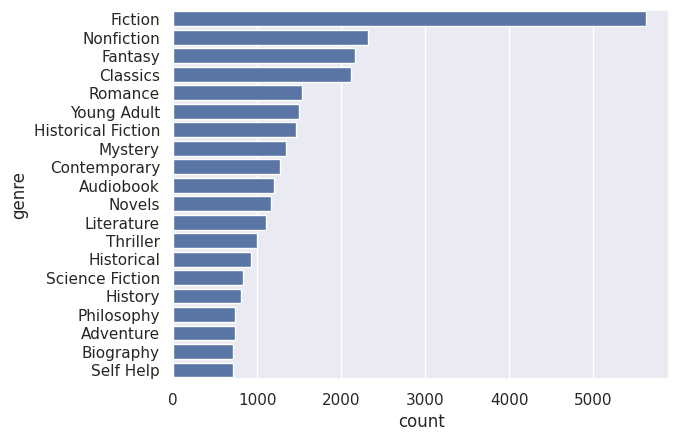

In [40]:
genres = []
for gen in df['Genres']:
    for g in gen:
        genres.append(g)
genres, genre_counts = np.unique(genres, return_counts=True)
genres = pd.DataFrame(data={'genre': genres, 'count': genre_counts}).sort_values(by='count', ascending=False)

print('Unique genre:', genres.shape[0])
sns.barplot(genres.head(20), y='genre', x='count')
plt.show()

#### Genre yang jarang muncul (kurang dari 50% buku)

Terdapat lebih dari 100 genre buku yang eksklusif hanya muncul pada 1 buku saja. Genre ini dapat diabaikan nanti

Text(0.5, 0, 'Genre occurence')

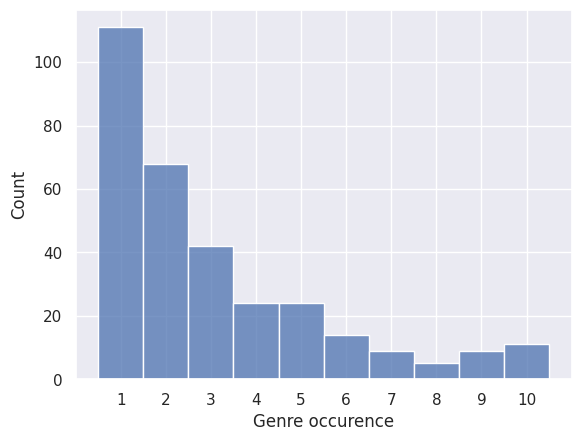

In [41]:
genre_occurence = genres['count'][genres['count'] <= genres['count'].quantile(.5)]
genre_occurence = [str(occ) for occ in genre_occurence][::-1]
sns.histplot(genre_occurence)
plt.xlabel('Genre occurence')

#### Sebaran jumlah genre tiap buku

Mayoritas buku memiliki 7 genre, terdapat juga beberapa buku yang memiliki 0 genre

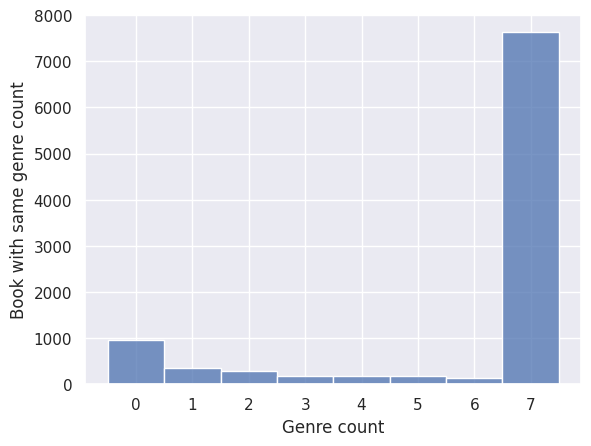

In [42]:
genre_count_per_title = []
for gen in df['Genres']:
    genre_count_per_title.append(len(gen))
genre_count_per_title = [str(gen) for gen in sorted(genre_count_per_title)]
sns.histplot(genre_count_per_title)
plt.xlabel('Genre count')
plt.ylabel('Book with same genre count')
plt.show()

### Observasi rating

Hasil rata-rata, standard deviasi, dan plot menunjukkan bahwa:
- "Rating" memiliki distribusi cenderung normal dengan titik tengah bernilai 4 yang cukup mendekati median
- "Jumlah rating" memiliki distribusi right skewed ditunjukkan dengan standard deviasi yang sangat tinggi dan rata-rata yang berada pada angka 87373 nilai ini berada pada 80.55% data

Karena ditemukan hasil seperti ini maka dapat diambil autran bahwa rating yang valid adalah yang memiliki jumlah penilai lebih dari 50% data, atau sekitar 15000 orang.

In [43]:
print(df.describe(), '\n')
print(f"Avg_Rating mean is on {sum(df['Avg_Rating'] < df['Avg_Rating'].mean()) / df.shape[0] * 100}% of data")
print(f"Num_Ratings mean is on {sum(df['Num_Ratings'] < df['Num_Ratings'].mean()) / df.shape[0] * 100}% of data")

        Avg_Rating   Num_Ratings
count  9896.000000  9.896000e+03
mean      4.066509  8.737353e+04
std       0.335470  3.083092e+05
min       0.000000  0.000000e+00
25%       3.880000  5.070000e+02
50%       4.070000  1.559150e+04
75%       4.260000  6.348975e+04
max       5.000000  9.278135e+06 

Avg_Rating mean is on 48.87833468067907% of data
Num_Ratings mean is on 80.55780113177042% of data


<Axes: xlabel='Avg_Rating', ylabel='Count'>

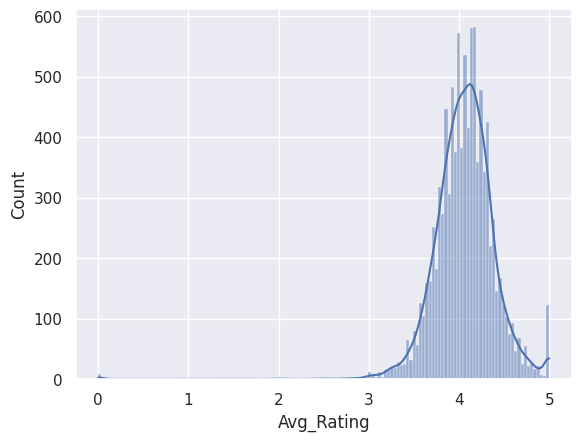

In [44]:
sns.histplot(df['Avg_Rating'], kde=True)

### Observasi author

#### Sebaran jumlah buku yang dihasilkan

Berdasarkan jumlah buku, 10 penulis teratas menulis sebanyak 20 buku atau lebih. Mayoritas penulis hanya menulis 1 buku saja.

There are 6064 authors
Average book per author is 1.6319261213720317


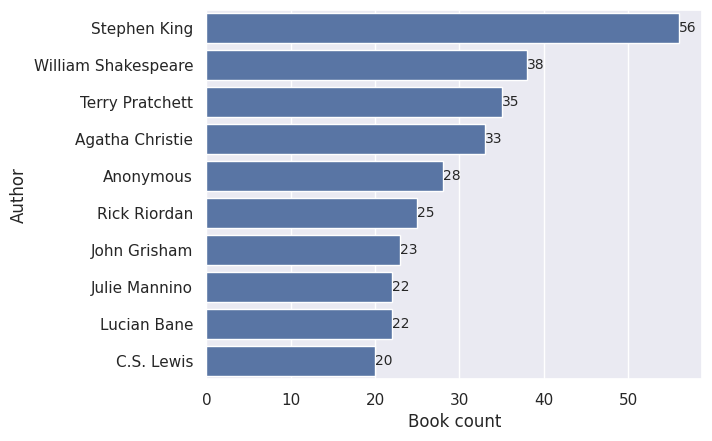

In [45]:
authors, book_count = np.unique(df['Author'], return_counts=True)
authors = pd.DataFrame(data={'author': authors, 'count': book_count}).sort_values(by='count', ascending=False)

print('There are', authors['author'].count(), 'authors')
print('Average book per author is', authors['count'].mean())

ax = sns.barplot(authors.head(10), y='author', x='count')
ax.bar_label(ax.containers[0], fontsize=10);

plt.ylabel('Author')
plt.xlabel('Book count')
plt.show()

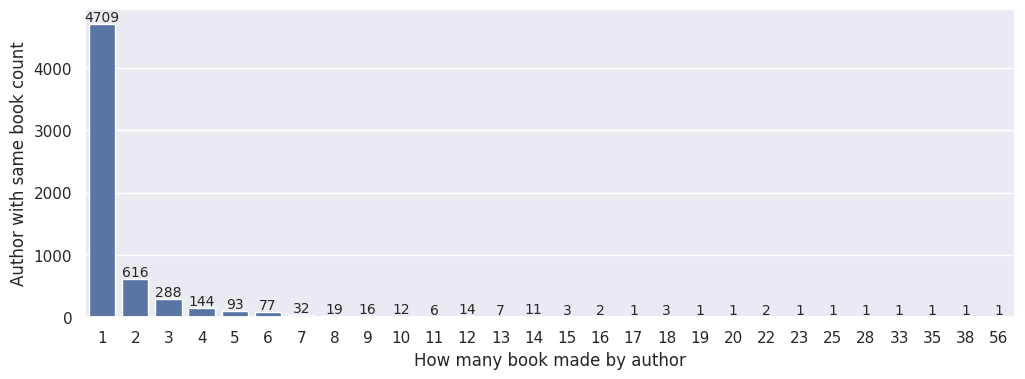

In [46]:
book_count, author_count = np.unique(book_count, return_counts=True)
book_count = pd.DataFrame(data={'author_book_count': book_count, 'count': author_count}).sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 4))
ax = sns.barplot(book_count, y='count', x='author_book_count')
ax.bar_label(ax.containers[0], fontsize=10);

plt.xlabel('How many book made by author')
plt.ylabel('Author with same book count')
plt.show()

#### 20 Author dengan rata-rata rating tertinggi

Sesuai hasil sebelumnya, rating valid hanya dihitung ketika jumlah penilai lebih dari 50% data

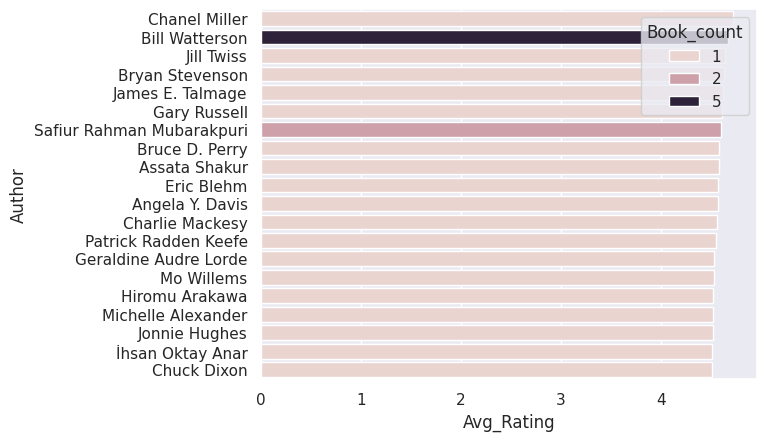

In [47]:
num_rating_treshold = df['Num_Ratings'].quantile(.5)
author_rate = df[df['Num_Ratings']>num_rating_treshold].groupby('Author').agg({
  'Avg_Rating': 'mean', 'Book': 'count'}
).reset_index().sort_values(by='Avg_Rating', ascending=False).rename(columns={'Book': 'Book_count'})
sns.barplot(author_rate.head(20), y='Author', x='Avg_Rating', hue='Book_count')
plt.show()

## Data Preparation

### Membuat data berdasarkan genre author

Berisi kumpulan genre buku yang ditulis oleh author, dalam bentuk list boleh berulang serta rating tiap author. Author yang tidak mencantumkan genre akan diabaikan.

In [48]:
author_df = df.groupby('Author').agg({'Avg_Rating': 'mean', 'Num_Ratings': 'sum', 'Book': 'count'}).reset_index()
author_df = author_df[author_df['Num_Ratings'] > author_df['Num_Ratings'].quantile(.5)]
rising_score = author_df['Avg_Rating'] / author_df['Num_Ratings']
rising_score = (rising_score - rising_score.min()) / (rising_score.max() - rising_score.min())
author_df['Rising_Score'] = rising_score

author_genres = []
for author in author_df['Author']:
    genres = []
    for genre in df[df['Author'] == author]['Genres']:
        genres.extend(genre)
    author_genres.append(genres)
        
author_df['Genres'] = author_genres
author_df.info()
# print(author_df.head().to_markdown())

<class 'pandas.core.frame.DataFrame'>
Index: 3031 entries, 1 to 6063
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Author        3031 non-null   object 
 1   Avg_Rating    3031 non-null   float64
 2   Num_Ratings   3031 non-null   int64  
 3   Book          3031 non-null   int64  
 4   Rising_Score  3031 non-null   float64
 5   Genres        3031 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 165.8+ KB


### Membersihkan data buku

- Membersihkan data buku dengan 1 atau tanpa genre sama sekali
- Membersihkan data buku dengan jumlah penilai kurang dari 50% sebaran data
- Menambahkan kolom rising score dengan nilai $\frac{rating\_score}{rating\_count}$

In [49]:
book_df = df.copy()
exclude_genre = book_df['Genres'].apply(lambda x: len(x) > 1)
book_df = book_df[exclude_genre][['Book', 'Author', 'Genres', 'Avg_Rating', 'Num_Ratings']]
book_df = book_df[book_df['Num_Ratings'] > num_rating_treshold]
rising_score = book_df['Avg_Rating'] / book_df['Num_Ratings']
rising_score = (rising_score - rising_score.min()) / (rising_score.max() - rising_score.min())
book_df['Rising_Score'] = rising_score
book_df.info()
# print(book_df.head().to_markdown())

<class 'pandas.core.frame.DataFrame'>
Index: 4948 entries, 0 to 9991
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Book          4948 non-null   object 
 1   Author        4948 non-null   object 
 2   Genres        4948 non-null   object 
 3   Avg_Rating    4948 non-null   float64
 4   Num_Ratings   4948 non-null   int64  
 5   Rising_Score  4948 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 270.6+ KB


### Inisialisasi TF-IDF

TF-IDF digunakan untuk menghitung vektor genre setiap buku

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

genre_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
genre_matrix = genre_vectorizer.fit_transform(book_df['Genres'])
author_matrix = genre_vectorizer.transform(author_df['Genres'])
print(genre_matrix.shape, author_matrix.shape)

(4948, 457) (3031, 457)


/home/izzudd/Dev/dicoding-mlt/.venv/lib64/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Modeling

In [51]:
def print_recommendation(book_df, title):
    print(title)
    for i, (_, row) in enumerate(book_df.iterrows()):
        print(f"{i+1:02}. {row['Book']} by {row['Author']}")
        print(f"    Rating: {row['Avg_Rating']:.2f}")
        print(f"    Genre : {', '.join(row['Genres'])}")
        
def print_author_recommendation(author_df, title):
    print(title)
    for i, (_, row) in enumerate(author_df.iterrows()):
        print(f"{i+1:02}. {row['Author']}, {row['Book']} book(s)")
        print(f"    Rating: {row['Avg_Rating']:.2f}")
        print(f"    Genre : {', '.join(set(row['Genres']))}")

### Rekomendasi buku berdasarkan genre

Mengambil masing-masing n buku berdasarkan genre paling cocok dan rising score tertinggi

In [52]:
from sklearn.metrics.pairwise import cosine_similarity

def genre_recommend(genres, vectorizer, genre_matrix, book_df, n=5, rising_treshold=.7, exclude_titles=[]):
    df = book_df.copy()
    target_vector = vectorizer.transform([genres])
    similarity_score = cosine_similarity(genre_matrix, target_vector)
    
    df['similarity'] = similarity_score
    df = df[~df['Book'].isin(exclude_titles)]
    
    df = df.sort_values(by=['similarity', 'Avg_Rating'], ascending=[False, False])
    top_book = df.head(n).sort_values(by='Avg_Rating', ascending=False)
    rising_book = df.tail(df.shape[0] - n)
    rising_book = rising_book[rising_book['Rising_Score'] > rising_treshold].head(n)
    rising_book = rising_book.sort_values(by='Avg_Rating', ascending=False)
    return top_book, rising_book

target_genre = ['Fantasy', 'Fiction', 'Young Adult', 'Magic', 'Childrens', 'Middle Grade', 'Classics']
top_book, rising_book = genre_recommend(target_genre, genre_vectorizer, genre_matrix, book_df)

print('Your favourite genres:', ', '.join(target_genre))
print_recommendation(top_book, '\nTop rated book with related genres')
print_recommendation(rising_book, '\nTop rising book with related genres')

# print(top_book[['Book', 'Author', 'Avg_Rating']].to_markdown())
# print(rising_book[['Book', 'Author', 'Avg_Rating']].to_markdown())

Your favourite genres: Fantasy, Fiction, Young Adult, Magic, Childrens, Middle Grade, Classics

Top rated book with related genres
01. Harry Potter and the Prisoner of Azkaban (Harry Potter, #3) by J.K. Rowling
    Rating: 4.58
    Genre : Fantasy, Fiction, Young Adult, Magic, Childrens, Middle Grade, Audiobook
02. Harry Potter and the Goblet of Fire (Harry Potter, #4) by J.K. Rowling
    Rating: 4.56
    Genre : Fantasy, Young Adult, Fiction, Magic, Childrens, Middle Grade, Audiobook
03. Harry Potter and the Philosopher’s Stone (Harry Potter, #1) by J.K. Rowling
    Rating: 4.47
    Genre : Fantasy, Fiction, Young Adult, Magic, Childrens, Middle Grade, Classics
04. Harry Potter and the Chamber of Secrets (Harry Potter, #2) by J.K. Rowling
    Rating: 4.43
    Genre : Fantasy, Fiction, Young Adult, Magic, Childrens, Middle Grade, Audiobook
05. Half Magic (Tales of Magic, #1) by Edward Eager
    Rating: 3.94
    Genre : Fantasy, Childrens, Fiction, Middle Grade, Classics, Young Adult, M

### Rekomendasi author

Memberikan n recomendasi author dengan genre tilisan yang mirip dengan author yang diberikan.

In [53]:
def author_recommendation(author_name, vectorizer, author_matrix, author_df, n=5, rising_treshold=.7):
    df = author_df.copy()
    genres = df[df['Author'] == author_name]['Genres'].values[0]
    target_vector = vectorizer.transform([genres])
    similarity_score = cosine_similarity(author_matrix, target_vector)
    
    df['similarity'] = similarity_score
    df = df[df['Author'] != author_name]
    df = df.sort_values(by=['similarity', 'Avg_Rating'], ascending=[False, False])
    top_author = df.head(n).sort_values(by='Avg_Rating', ascending=False)
    
    rising_author = df.tail(df.shape[0] - n)
    rising_author = rising_author[rising_author['Rising_Score'] > rising_treshold].head(n)
    rising_author = rising_author.sort_values(by='Avg_Rating', ascending=False)
    return top_author, rising_author

author_name = 'J.K. Rowling'
top_author, rising_author = author_recommendation(author_name, genre_vectorizer, author_matrix, author_df)

print('Author with simmilar taste like', author_name)
print_author_recommendation(top_author, '\nTop rated simmilar author')
print_author_recommendation(rising_author, '\nTop rising simmilar author')

# print(top_author[['Author', 'Book', 'Avg_Rating']].to_markdown())
# print(rising_author[['Author', 'Book', 'Avg_Rating']].to_markdown())

Author with simmilar taste like J.K. Rowling

Top rated simmilar author
01. Shannon Messenger, 2 book(s)
    Rating: 4.48
    Genre : Fiction, Adventure, Magic, Middle Grade, Young Adult, Childrens, Fantasy
02. Kelly Barnhill, 1 book(s)
    Rating: 4.12
    Genre : Fiction, Magic, Middle Grade, Young Adult, Audiobook, Childrens, Fantasy
03. Newt Scamander, 1 book(s)
    Rating: 3.96
    Genre : Fiction, Magic, Middle Grade, Young Adult, Audiobook, Childrens, Fantasy
04. Jenny Nimmo, 2 book(s)
    Rating: 3.87
    Genre : Fiction, Magic, Adventure, Middle Grade, Young Adult, Childrens, Fantasy
05. Kennilworthy Whisp, 1 book(s)
    Rating: 3.81
    Genre : Fiction, Magic, Middle Grade, Young Adult, Audiobook, Childrens, Fantasy

Top rising simmilar author
01. Robyn Mundell, 1 book(s)
    Rating: 4.33
    Genre : Fiction, Adventure, Middle Grade, Science Fiction Fantasy, Young Adult, Childrens, Fantasy
02. Sienna Mercer, 2 book(s)
    Rating: 4.19
    Genre : Vampires, Fiction, Middle Gra

### Rekomendasi berdsarkan riwayat baca

In [54]:
def history_recommend(histories, vectorizer, genre_matrix, book_df, n=5, rising_treshold=.7):
    genres = []
    for history in histories:
        genre = book_df[book_df['Book'] == history]['Genres']
        genres.extend(*genre)
        
    return genre_recommend(genres, vectorizer, genre_matrix, book_df, n=5, rising_treshold=rising_treshold, exclude_titles=histories)
    
read_history = [
    "Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)",
    "Harry Potter and the Chamber of Secrets (Harry Potter, #2)",
    "Harry Potter and the Philosopher’s Stone (Harry Potter, #1)",
]
top_book, rising_book = history_recommend(read_history, genre_vectorizer, genre_matrix, book_df)
print('Recomendation based on your previous avtivities\n- ', '\n- '.join(read_history), sep='')
print_recommendation(top_book, '\nTop rated book with simmilar taste')
print_recommendation(rising_book, '\nTop rising book with simmilar taste')

# print(top_book[['Book', 'Author', 'Avg_Rating']].to_markdown())
# print(rising_book[['Book', 'Author', 'Avg_Rating']].to_markdown())

Recomendation based on your previous avtivities
- Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)
- Harry Potter and the Chamber of Secrets (Harry Potter, #2)
- Harry Potter and the Philosopher’s Stone (Harry Potter, #1)

Top rated book with simmilar taste
01. Harry Potter and the Goblet of Fire (Harry Potter, #4) by J.K. Rowling
    Rating: 4.56
    Genre : Fantasy, Young Adult, Fiction, Magic, Childrens, Middle Grade, Audiobook
02. The Girl Who Drank the Moon by Kelly Barnhill
    Rating: 4.12
    Genre : Fantasy, Middle Grade, Fiction, Young Adult, Childrens, Magic, Audiobook
03. Fantastic Beasts and Where to Find Them by Newt Scamander
    Rating: 3.96
    Genre : Fantasy, Fiction, Young Adult, Childrens, Magic, Middle Grade, Audiobook
04. Half Magic (Tales of Magic, #1) by Edward Eager
    Rating: 3.94
    Genre : Fantasy, Childrens, Fiction, Middle Grade, Classics, Young Adult, Magic
05. Quidditch Through the Ages by Kennilworthy Whisp
    Rating: 3.81
    Genre : Fan

## Evaluasi

### Ambil sampel buku yang sudah dibaca

Membuat simulasi 3000 user yang masing-masing membaca 5 buku sebagai bahan pengujian. Sampel diambil secara random, sehingga belum tentu dapat menggambarkan keadaan dunia sebenarnya.

In [122]:
def sample_user_book(user_count, n_book, book_df):
    users = {'History': [], 'Genres': []}
    for i in range(user_count):
        history = []
        genres = []
        for _, row in book_df.sample(n_book).iterrows():
            history.append(row['Book'])
            genres.extend(row['Genres'])
        users['History'].append(history)
        users['Genres'].append(genres)
    return pd.DataFrame(users)

user_sample = sample_user_book(3000, 4, book_df)

### Metrik evaluasi

$$\begin{align}
Recall@k &= \frac{\text{jumlah item relevan pada k}}{\text{jumlah item relevan}} \\
Precision@k &= \frac{\text{jumlah item relevan pada k}}{\text{jumlah item pada k}} \\
F1@k &= \frac{Precission@k \times Recall@k}{Precission@k + Recall@k}
\end{align}$$

In [123]:
def recall_k(target_books, recommendations):
    relevant_items = set.intersection(target_books, recommendations)
    return len(relevant_items) / len(target_books)

def precision_k(target_books, recommendations):
    relevant_items = set.intersection(target_books, recommendations)
    return len(relevant_items) / len(recommendations)

def f1_k(target_books, recommendations):
    recall = recall_k(target_books, recommendations)
    precision = precision_k(target_books, recommendations)
    return (recall*precision) / (recall+precision) if (recall+precision) > 0 else 0

### Evaluasi model

Model akan merekomendasikan 10 judul buku berdsarkan genre 4 buku yang telah dibaca oleh user sebelumnya. Perhitungan metrik dilakukan dengan skor Recall, Precision, dan F1

In [124]:
metrics = {
    'recall': [],
    'precision': [],
    'f1': [],
}

for _, sample in user_sample.iterrows():
    history = set(sample['History'])
    genres = sample['Genres']
    
    top_book, _ = genre_recommend(genres, genre_vectorizer, genre_matrix, book_df, n=10)
    recomended = set(top_book['Book'])
    
    metrics['recall'].append(recall_k(history, recomended))
    metrics['precision'].append(precision_k(history, recomended))
    metrics['f1'].append(f1_k(history, recomended))
    
metrics = pd.DataFrame(metrics)
print(metrics.mean().to_markdown())

|           |        0 |
|:----------|---------:|
| recall    | 0.552583 |
| precision | 0.221122 |
| f1        | 0.157925 |


Metrik tersebut menjelaskan beberapa hal, diantaranya:
- Berdasarkan skor recall: dari total 4 buku yang dibaca user, 2 diantaranya berhasil diprediksi oleh sistem rekomendasi
- Berdasarkan skor precision: dari total 10 buku hasil rekomendasi, 2 diantaranya pernah dibaca user
- Berdasarkan skor F1: akruasi prediksi sistem rekomendasi adalah 15%

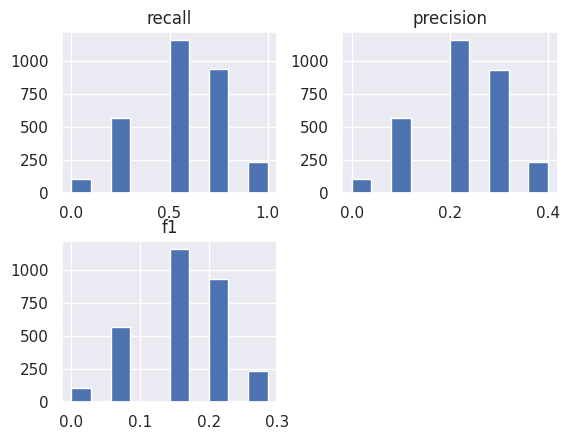

In [125]:
metrics.hist()
plt.show()